<a href="https://colab.research.google.com/github/Brayden-Zhang/Land-Classification/blob/main/Land_Use_and_Land_Cover_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Land Use and Land Cover Classification**





Credit to Ankur Mahesh, Isabelle Tingzon, and CCAI for the tutorial in which this notebook is mostly based on.

## Library imports

In [1]:
# Standard libraries
import os
import random
from tqdm.notebook import tqdm

# Data manipulation and visualization
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np

# Deep Learning libraries
import torch
import torchvision
import torchsummary
from torch.utils import data
from torchvision import datasets, models, transforms

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

In [2]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: Tesla T4


## *Data* Processing

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip -O EuroSAT.zip
!unzip -q EuroSAT.zip -d 'EuroSAT/'
!rm EuroSAT.zip

--2024-05-12 15:45:35--  http://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M  19.1MB/s    in 5.7s    

2024-05-12 15:45:41 (15.8 MB/s) - ‘EuroSAT.zip’ saved [94280567/94280567]



In [5]:
class EuroSAT(data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        # Apply image transformations
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = dataset[index][0]
        # Get class label
        y = dataset[index][1]
        return x, y

    def __len__(self):
        return len(dataset)

### Data Augmentation


In [6]:
input_size = 224
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

Loading EuroSAT Dataset


In [7]:
data_dir = './EuroSAT/2750/'

dataset = datasets.ImageFolder(data_dir)

class_names = dataset.classes
print("Class names: {}".format(class_names))
print("total num of classes: {}".format(len(class_names)))


Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
total num of classes: 10


In [ ]:
def load_data(data_dir = 'EuroSAT/2750/'):
  train_data = EuroSAT(dataset, train_transform)
  test_data = EuroSAT(dataset, test_transform)

  return train_data, test_data


In [8]:
# split into train/test sets

train_data = EuroSAT(dataset, train_transform)
test_data = EuroSAT(dataset, test_transform)


train_size = 0.8

indices = list(range(int(len(dataset))))
split = int(train_size * len(dataset))
np.random.shuffle(indices)

train_data = data.Subset(train_data, indices = indices[:split])
test_data = data.Subset(test_data, indices=indices[split:])
print("Train/test sizes: {}/{}".format(len(train_data), len(test_data)))

Train/test sizes: 21600/5400


In [9]:
num_workers = 2
batch_size = 16
train_loader = data.DataLoader(
    train_data, batch_size = batch_size, num_workers=num_workers, shuffle=True
)
test_loader = data.DataLoader(
    train_data, batch_size = batch_size, num_workers=num_workers, shuffle=False
)




/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


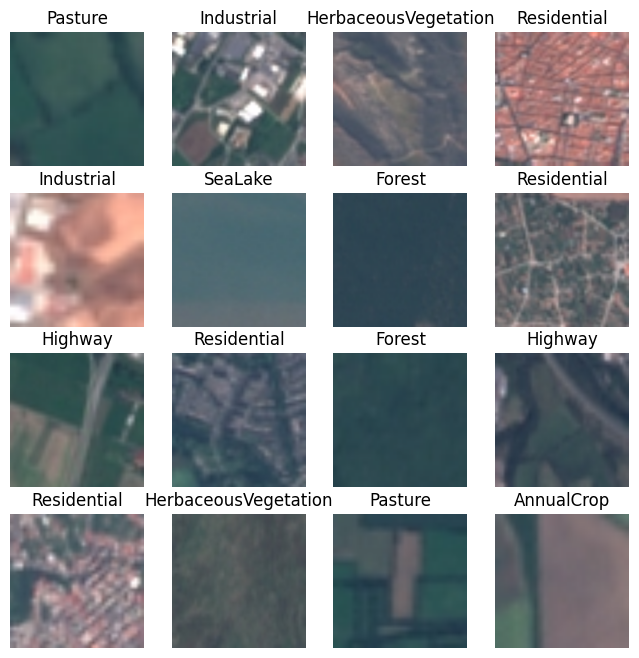

In [10]:

# visualizing data

n = 4
inputs, classes = next(iter(train_loader))
fig, axes = plt.subplots(n, n, figsize=(8,8))

for i in range(n):
  for j in range(n):
    image = inputs[i * n + j].numpy().transpose((1, 2, 0))
    image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

    title = class_names[classes[i * n + j]]
    axes[i, j].imshow(image)
    axes[i, j].set_title(title)
    axes[i, j].axis('off')


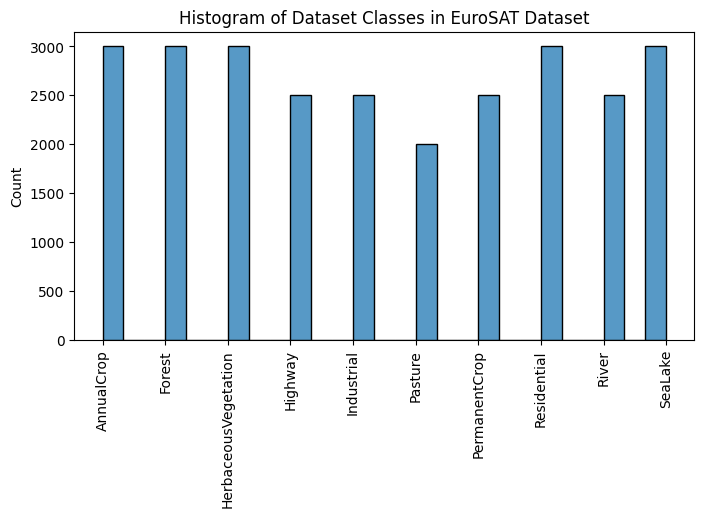

In [11]:
plt.figure(figsize=(8, 4))
hist = sns.histplot(dataset.targets)

hist.set_xticks(range(len(dataset.classes)))
hist.set_xticklabels(dataset.classes, rotation=90)
hist.set_title('Histogram of Dataset Classes in EuroSAT Dataset')

plt.show()

## Model

In [12]:


model = models.resnet50(pretrained = True)
model.fc = torch.nn.Linear(model.fc.in_features, len(dataset.classes))
model = model.to(device)


torchsummary.summary(model, (3, 224, 244))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 144MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 122]           9,408
       BatchNorm2d-2         [-1, 64, 112, 122]             128
              ReLU-3         [-1, 64, 112, 122]               0
         MaxPool2d-4           [-1, 64, 56, 61]               0
            Conv2d-5           [-1, 64, 56, 61]           4,096
       BatchNorm2d-6           [-1, 64, 56, 61]             128
              ReLU-7           [-1, 64, 56, 61]               0
            Conv2d-8           [-1, 64, 56, 61]          36,864
       BatchNorm2d-9           [-1, 64, 56, 61]             128
             ReLU-10           [-1, 64, 56, 61]               0
           Conv2d-11          [-1, 256, 56, 61]          16,384
      BatchNorm2d-12          [-1, 256, 56, 61]             512
           Conv2d-13          [-1, 256, 56, 61]          16,384
      BatchNorm2d-14          [-1, 256,

In [13]:
# hyperparams

n_epochs = 4
lr = 1e-3

criterion = torch.nn.CrossEntropyLoss()
optimizer  = torch.optim.SGD(model.parameters(), lr = lr)


In [14]:
def train(model, dataloader, criterion, optimizer):
  model.train()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    # move to GPU
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Zero the parameter gradients
    # Clear off previous weights in order
    # to obtain updated weights.
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)

    # Compute the loss
    loss = criterion(outputs, labels)

    # Compute the gradients wrt the loss
    loss.backward()

    # Update the weights based on the
    # internally stored gradients
    optimizer.step()

    # Calculate statistics
    _, preds = torch.max(outputs, 1)

    # Calculate running loss and accuracy
    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print("Train Loss: {:.2f}; Accuracy: {:.2f}".format(epoch_loss, epoch_accuracy))

  return epoch_loss, epoch_accuracy

In [15]:
def evaluate(model, dataloader, criterion):
  model.eval()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)

    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print("Test Loss: {:.2f}; Accuracy: {:.2f}".format(epoch_loss, epoch_accuracy))

  return epoch_loss, epoch_accuracy

In [16]:
# Keep track of the best loss and
# best model weights with the lowest loss
best_loss = np.inf
best_model = None

# Train and test over n_epochs
for epoch in range(n_epochs):
  print("Epoch {}".format(epoch+1))
  train(model, train_loader, criterion, optimizer)
  test_loss, _ = evaluate(model, test_loader, criterion)

  if test_loss < best_loss:
    best_loss = test_loss
    best_model= model.state_dict()

Epoch 1


  0%|          | 0/1350 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Train Loss: 1.01; Accuracy: 70.30


  0%|          | 0/1350 [00:00<?, ?it/s]

Test Loss: 0.42; Accuracy: 87.49
Epoch 2


  0%|          | 0/1350 [00:00<?, ?it/s]

Train Loss: 0.48; Accuracy: 84.89


  0%|          | 0/1350 [00:00<?, ?it/s]

Test Loss: 0.27; Accuracy: 91.82
Epoch 3


  0%|          | 0/1350 [00:00<?, ?it/s]

Train Loss: 0.37; Accuracy: 88.20


  0%|          | 0/1350 [00:00<?, ?it/s]

Test Loss: 0.21; Accuracy: 93.41
Epoch 4


  0%|          | 0/1350 [00:00<?, ?it/s]

Train Loss: 0.32; Accuracy: 89.92


  0%|          | 0/1350 [00:00<?, ?it/s]

Test Loss: 0.20; Accuracy: 93.68


In [17]:
model_dir = "./drive/My Drive/Colab Notebooks/models/"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

model_file = model_dir + 'best_model.pth'
torch.save(best_model, model_file)
print('Model successfully saved to {}'.format(model_file))

Model successfully saved to ./drive/My Drive/Colab Notebooks/models/best_model.pth


In [19]:
model_dir = "./drive/My Drive/Colab Notebooks/models/"
model_file = os.path.join(model_dir, 'best_model.pth')

# Uncomment this to download the model file
#if not os.path.isfile(model_file):
#  model_file = 'best_model.pth'
#  !gdown "13AFOESwxKmexCoOeAbPSX_wr-hGOb9YY"

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model.load_state_dict(torch.load(model_file))
model.eval()

print('Model file {} successfully loaded.'.format(model_file))

Model file ./drive/My Drive/Colab Notebooks/models/best_model.pth successfully loaded.


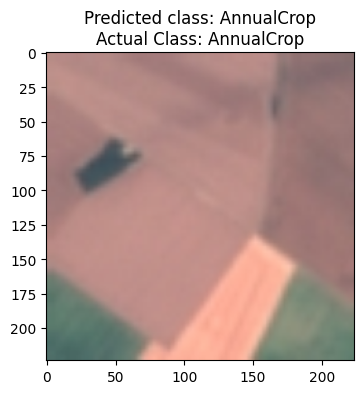

In [25]:
# Retrieve sample image
index = 24
image, label = test_data[index]

# Predict on sample
output = model(image.unsqueeze(0))
_, pred = torch.max(output, 1)

# Get corresponding class label
label = class_names[label]
pred = class_names[pred[0]]

# Visualize sample and prediction
image = image.cpu().numpy().transpose((1, 2, 0))
image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(image)
ax.set_title("Predicted class: {}\nActual Class: {}".format(pred, label));

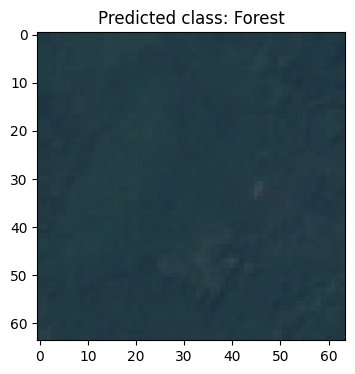

In [24]:
from PIL import Image
image_path = './EuroSAT/2750/Forest/Forest_3.jpg'
image = Image.open(image_path)

# Transform image
input = test_transform(image)

# Predict on sample
output = model(input.unsqueeze(0))

# Get corresponding class label
_, pred = torch.max(output, 1)
pred = class_names[pred[0]]

# Visualize results
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(image)
ax.set_title("Predicted class: {}".format(pred));

# References
- Helber, P., Bischke, B., Dengel, A., & Borth, D. (2019). Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 12(7), 2217-2226.


- Ankur Mahesh and Isabelle Tingzon, Climate Change AI